
# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and its variations. You will learn how to encode images into latent vectors follow gaussian distribution, and how to control images decoded from latent spaces with condtional variational autoencoder.

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, one_hot

In [88]:
#Use this if you are running on any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Load MNIST Dataset

In [103]:
# TODO
input_dim = 28*28
hidden_dim = 100
latent_dim = 15
batch_size = 50
n_epochs = 15
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

num_classes = 10
portioned_img_size = 14*14

mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

mnist_test = datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True, train=False)

loader_test = DataLoader(mnist_test, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)                        

In [104]:
class myVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, conditional_vec_dim=0):
        super(myVAE, self).__init__()
        self.input_dim =  input_dim # H*W
        self.latent_dim =  latent_dim # Z
        self.hidden_dim = hidden_dim 
        self.conditional_vec_dim = conditional_vec_dim # only used in CVAE

        self.encoder = nn.Sequential(
            nn.Flatten(2,3),
            nn.Linear(self.input_dim+self.conditional_vec_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,self.hidden_dim),
            nn.ReLU()
        ) # input: (N,1,H,W) -> output: (N,hidden_dim)
        self.mean_layer = nn.Linear(self.hidden_dim,self.latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        self.logvar_layer = nn.Linear(self.hidden_dim,self.latent_dim)  # input: (N,hidden_dim) -> output: (N, Z)
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim+self.conditional_vec_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,self.input_dim),
            nn.Sigmoid(),
            nn.Unflatten(2,(28,28))
        )  # input: (N, Z) -> output: (N,1,H,W)
        
    def forward(self, x,c=torch.zeros(1)):
        # TODO
        if torch.any(c)==0:
            encoder_out = self.encoder(x)
            mu = self.mean_layer(encoder_out)
            logvar = self.logvar_layer(encoder_out)
            z=self.reparametrize(mu,logvar)
            x_hat=self.decoder(z)
        else:
            cond_input=torch.cat([x,c],1).unsqueeze(1).unsqueeze(3)
            encoder_out=self.encoder(cond_input)
            mu=self.mean_layer(encoder_out)
            logvar=self.logvar_layer(encoder_out)
            z=self.reparametrize(mu,logvar)
            cond_z=torch.cat([z,c.unsqueeze(1)],2)
            x_hat=self.decoder(cond_z)

        return x_hat,mu,logvar

    @staticmethod
    def reparametrize(mu, logvar):
        # TODO:
        sigma=torch.sqrt(torch.exp(logvar))
        z = sigma*torch.randn_like(mu)+mu
        return z

    def loss_function(self,x_hat, x, mu, logvar):
        # TODO: Compute negative variational lowerbound loss as described in the handout
        KL_loss = (1+logvar-mu**2-torch.exp(logvar))
        KL_loss= -0.5*KL_loss.sum()
        reconstruction_loss = nn.functional.binary_cross_entropy(x_hat,x,reduction='sum')
        # reconstruction_loss = nn.functional.binary_cross_entropy_with_logits(x_hat,x)
        loss = (KL_loss+reconstruction_loss)/mu.shape[0]

        return loss

In [109]:
from torchsummary import summary
vae = myVAE(input_dim, hidden_dim, latent_dim).to(device)
summary(vae,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 1, 784]               0
            Linear-2               [-1, 1, 100]          78,500
              ReLU-3               [-1, 1, 100]               0
            Linear-4               [-1, 1, 100]          10,100
              ReLU-5               [-1, 1, 100]               0
            Linear-6               [-1, 1, 100]          10,100
              ReLU-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 15]           1,515
            Linear-9                [-1, 1, 15]           1,515
           Linear-10               [-1, 1, 100]           1,600
             ReLU-11               [-1, 1, 100]               0
           Linear-12               [-1, 1, 100]          10,100
             ReLU-13               [-1, 1, 100]               0
           Linear-14               [-1,

## Train

In [106]:
#TODO
optimizer = torch.optim.Adam(vae.parameters(),lr=0.001)
loss_history=[]
for epoch in range(n_epochs):
  vae.train()
  train_loss = 0
  loss = vae.loss_function
  for batch_idx, (data, labels) in enumerate(loader_train):
      #TODO
      optimizer.zero_grad()# clear the gradients of all optimized variables
      out,mu,logvar=vae(data)# forward pass:
      l=loss(out,data,mu,logvar)# calculate the loss using the loss function defined above
      l.backward()# backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()# perform a single optimization step (parameter update)
      train_loss+=l# update running training loss
  
  train_loss = train_loss/len(loader_train)
  loss_history.append(train_loss.item())
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 187.765076
Epoch: 1 	Training Loss: 143.297546
Epoch: 2 	Training Loss: 131.107849
Epoch: 3 	Training Loss: 126.195511
Epoch: 4 	Training Loss: 122.819542
Epoch: 5 	Training Loss: 120.878075
Epoch: 6 	Training Loss: 119.459892
Epoch: 7 	Training Loss: 118.389778
Epoch: 8 	Training Loss: 117.591423
Epoch: 9 	Training Loss: 116.974884
Epoch: 10 	Training Loss: 116.448753
Epoch: 11 	Training Loss: 115.926926
Epoch: 12 	Training Loss: 115.524261
Epoch: 13 	Training Loss: 115.176117
Epoch: 14 	Training Loss: 114.825821


Results

sampled image


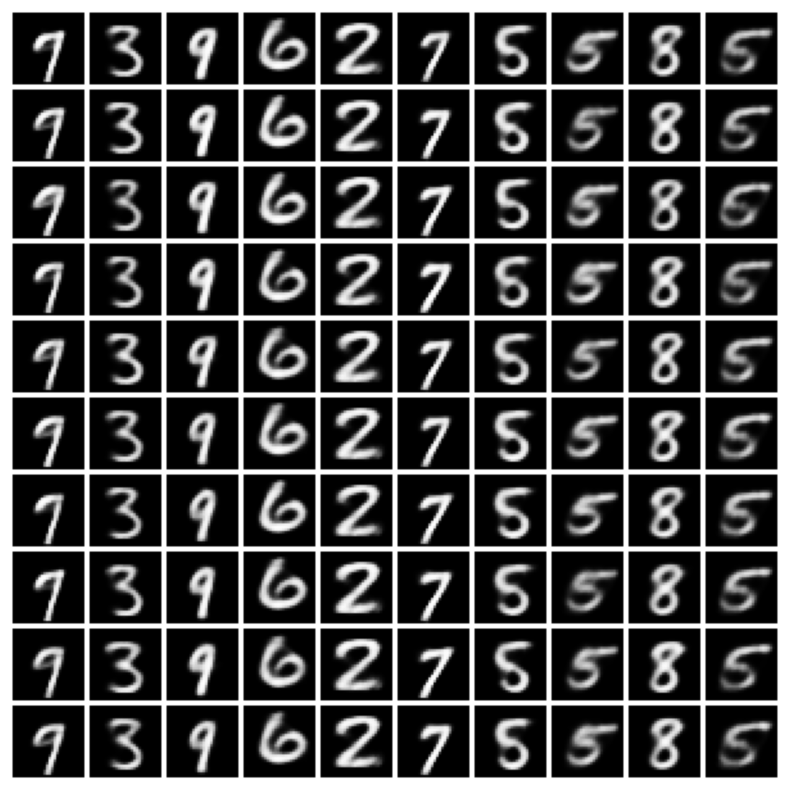

sampled image with larger variance


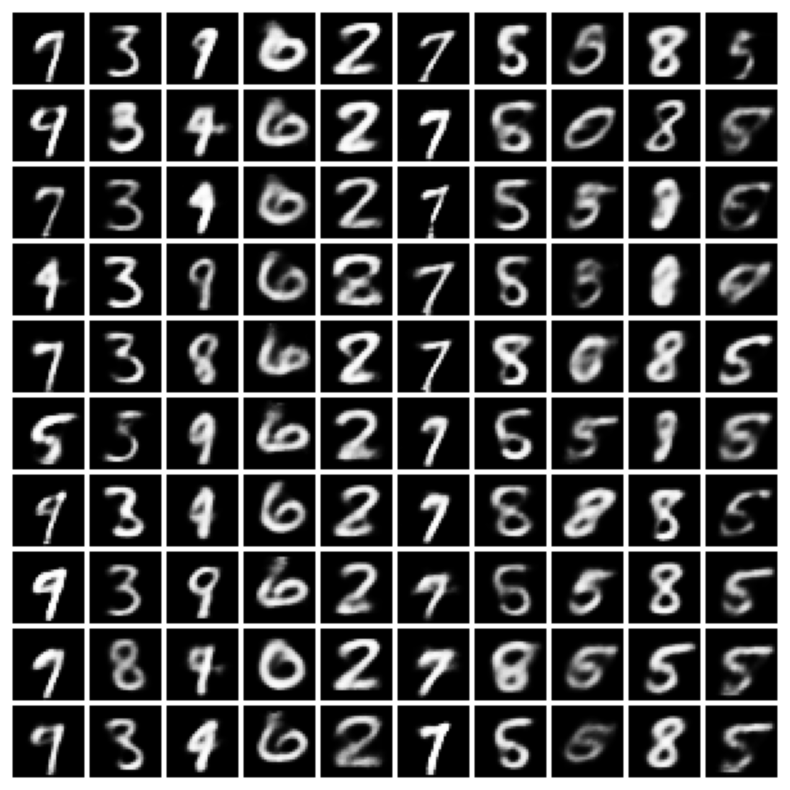

In [107]:
vae.eval()
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10
images = images.repeat(10,1,1,1)

samples, mu, logvar = vae(images.to(device))
# show vae sampled images
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

z = myVAE.reparametrize(mu, logvar+3)
samples = vae.decoder(z)

# show vae sampled images with larger variance
print('sampled image with larger variance')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

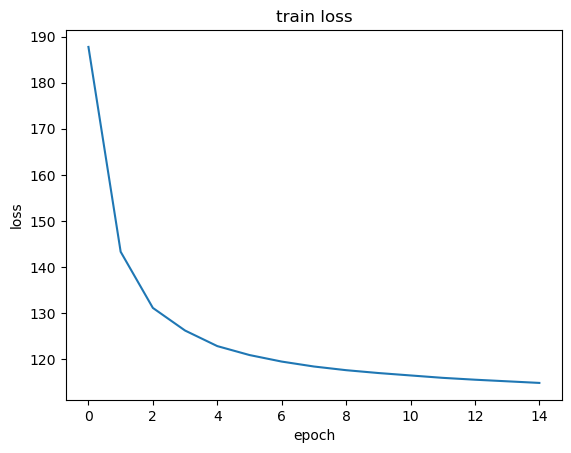

In [108]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

# CVAE

In [95]:
cvae = myVAE(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, conditional_vec_dim=num_classes).to(device)
optimizer = torch.optim.Adam(cvae.parameters(),lr=0.01)
loss_history=[]
for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = cvae.loss_function
  for batch_idx, (data, labels) in enumerate(loader_train):
      onehot=one_hot(labels,10)# Calculate the onehot vector based on the label, use the pre-defined function
      optimizer.zero_grad()# clear the gradients of all optimized variables
      i=data.reshape(-1,784)
      out,mu,logvar=cvae(i,onehot)# Forward pass with the one-hot vector
      out = torch.clip(out, 0., 1.)
      l=loss(out,data,mu,logvar)# calculate the loss using the loss function defined above
      l.backward()# backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()# perform a single optimization step (parameter update)
      train_loss+=l# update running training loss
      
  train_loss = train_loss/len(loader_train)
  loss_history.append(train_loss.item())
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 163.273300
Epoch: 1 	Training Loss: 151.733093
Epoch: 2 	Training Loss: 148.140579
Epoch: 3 	Training Loss: 146.154770
Epoch: 4 	Training Loss: 144.432968
Epoch: 5 	Training Loss: 142.734680
Epoch: 6 	Training Loss: 142.041718
Epoch: 7 	Training Loss: 141.420029
Epoch: 8 	Training Loss: 140.875137
Epoch: 9 	Training Loss: 140.555359
Epoch: 10 	Training Loss: 140.119812
Epoch: 11 	Training Loss: 139.826920
Epoch: 12 	Training Loss: 139.417267
Epoch: 13 	Training Loss: 139.249374
Epoch: 14 	Training Loss: 138.961395


## Results

sampled image


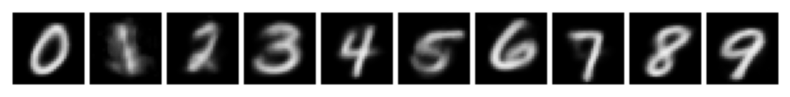

In [96]:
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device).unsqueeze(1)
cvae.eval()
samples = cvae.decoder(z)
# show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

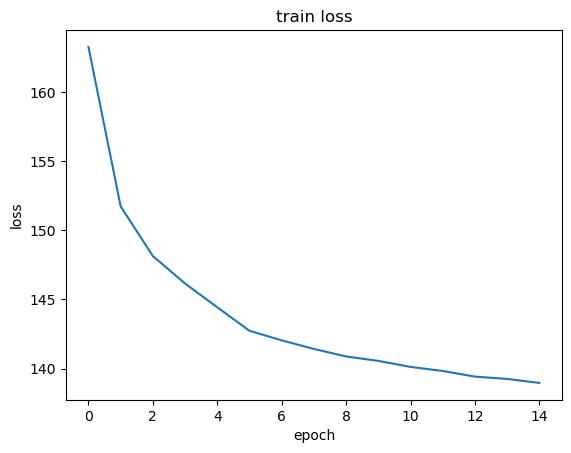

In [97]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## CVAE + structured output prediction

In [98]:
cvae = myVAE(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, conditional_vec_dim = portioned_img_size).to(device=device)
optimizer = torch.optim.Adam(cvae.parameters(),lr=0.01)
loss_history=[]
for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = cvae.loss_function
  for batch_idx, (data, labels) in enumerate(loader_train):
      sliced_image=data[:,:,14:28,0:14]# Slice the bottom left portion of the image
      sliced_image=sliced_image.reshape(-1,196)# Flatten it/ reshape it to (-1,14*14)
      optimizer.zero_grad()# clear the gradients of all optimized variables
      i=data.reshape(-1,784)
      out,mu,logvar=cvae(i,sliced_image)# Forward pass with the conditional vector
      l=loss(out,data,mu,logvar)# calculate the loss using the loss function defined above
      l.backward()# backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()# perform a single optimization step (parameter update)
      train_loss+=l# update running training loss

  train_loss = train_loss/len(loader_train)
  loss_history.append(train_loss.item())
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 128.801346
Epoch: 1 	Training Loss: 117.009048
Epoch: 2 	Training Loss: 115.952225
Epoch: 3 	Training Loss: 115.276642
Epoch: 4 	Training Loss: 114.775650
Epoch: 5 	Training Loss: 114.427307
Epoch: 6 	Training Loss: 114.312553
Epoch: 7 	Training Loss: 114.089493
Epoch: 8 	Training Loss: 113.999664
Epoch: 9 	Training Loss: 113.800537
Epoch: 10 	Training Loss: 113.664558
Epoch: 11 	Training Loss: 113.694412
Epoch: 12 	Training Loss: 113.557228
Epoch: 13 	Training Loss: 113.486275
Epoch: 14 	Training Loss: 113.340622


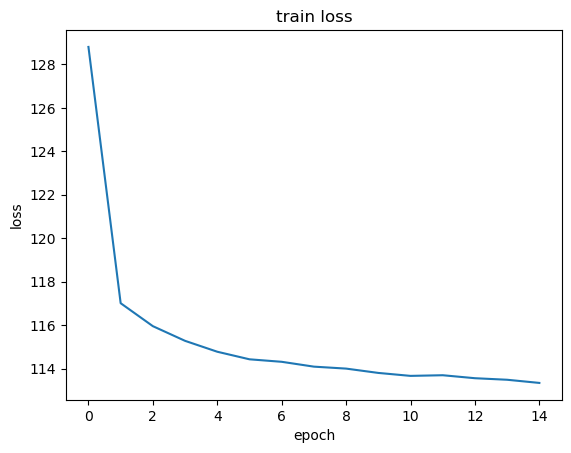

In [99]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## Baseline NN for structured output prediction

In [100]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim=input_dim
        self.hidden_dim=100
        self.decoder=nn.Sequential(
            nn.Flatten(2,3),
            nn.Linear(self.input_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim,784),
            nn.ReLU(),
            nn.Unflatten(2,(28,28))
        )

    def forward(self, z):
        z=self.decoder(z)
        return z

In [101]:
baseline =  BaselineNN(input_dim = portioned_img_size).to(device)
criterion = nn.MSELoss() #TODO
optimizer = torch.optim.Adam(baseline.parameters(),lr=0.001) #TODO

for epoch in range(0, n_epochs):
  baseline.train()
  train_loss = 0
  loss = criterion
  for batch_idx, (data, labels) in enumerate(loader_train):
      sliced_image=data[:,:,14:28,0:14]# Slice the bottom left portion of the image
      # Flatten it/ reshape it to (-1,14*14)
      optimizer.zero_grad()# clear the gradients of all optimized variables
      out=baseline(sliced_image)# Forward pass with the conditional vector as input
      l=criterion(data,out)# calculate the loss using the criterion function defined above
      l.backward()# backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()# perform a single optimization step (parameter update)
      train_loss+=l# update running training loss
      
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.042827
Epoch: 1 	Training Loss: 0.035926
Epoch: 2 	Training Loss: 0.034761
Epoch: 3 	Training Loss: 0.033818
Epoch: 4 	Training Loss: 0.033162
Epoch: 5 	Training Loss: 0.032648
Epoch: 6 	Training Loss: 0.032319
Epoch: 7 	Training Loss: 0.032138
Epoch: 8 	Training Loss: 0.031993
Epoch: 9 	Training Loss: 0.031886
Epoch: 10 	Training Loss: 0.031768
Epoch: 11 	Training Loss: 0.031669
Epoch: 12 	Training Loss: 0.031592
Epoch: 13 	Training Loss: 0.031534
Epoch: 14 	Training Loss: 0.031480


## Results

Ground truth


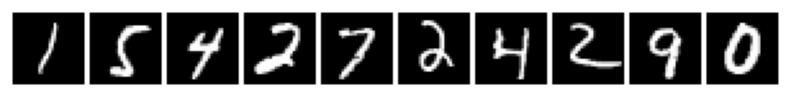

Quarter image


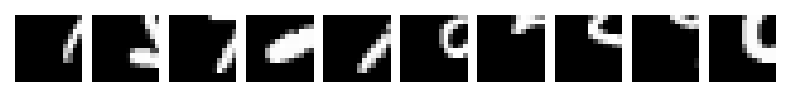

Baseline results


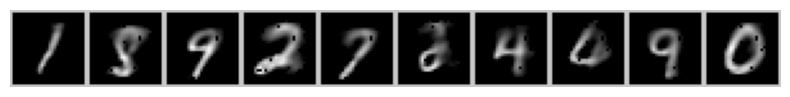

CVAE results


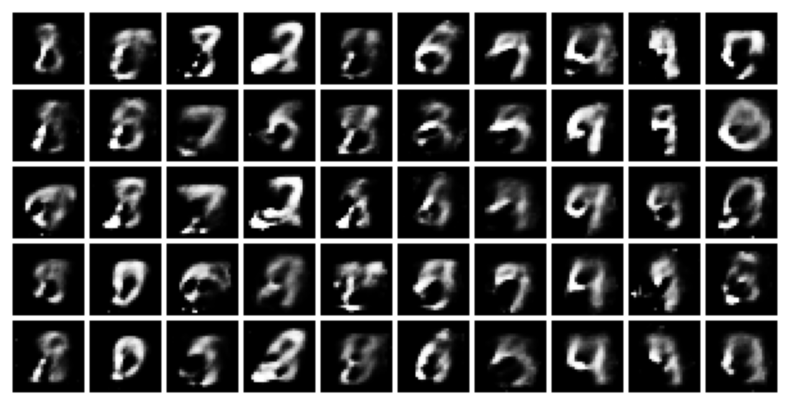

In [102]:
full_imgs = next(iter(loader_test))[0][0:10,:,:,:]
# TODO
# Slice the bottom left portion of the image
quad_imgs = full_imgs[:,:,14:28,0:14] #(10,1,14,14)

print('Ground truth')
visualize_img_batch(full_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Quarter image')
visualize_img_batch(quad_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Baseline results')
baseline.eval()
samples = baseline(quad_imgs.to(device))
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

print('CVAE results')
cvae.eval()
num_random = 5
quad_imgs = quad_imgs.repeat(num_random ,1,1,1)
quad_imgs = torch.reshape(quad_imgs,(-1, 14*14))

z = torch.randn(num_random*10, latent_dim)
z = torch.cat([quad_imgs,z],1).unsqueeze(1) #TODO: concat latent vector with the conditional_vec (quad_imgs)
samples = cvae.decoder(z).data
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()